### This notebook is to look at labs data closely, do some EDA.

## Imports

In [29]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import func, select, desc
from sqlalchemy.sql.expression import and_

import config
from cyclops.orm import DB

## Load config, setup ORM

In [3]:
cfg = config.read_config("../configs/default/*.yaml")
db = DB(cfg)

## Find out unique lab tests

In [34]:
"""Unique lab names and counts. Get top k lab tests ordered.

`lab_test_name_mapped` has common tests mapped across sites by GEMINI.
`lab_test_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""

k = 54
UNIQUE_LAB_NAMES = "unique_lab_names"
UNIQUE_LAB_COUNTS = "unique_lab_counts"

unique_lab_names = func.lower(db.public.lab.lab_test_name_mapped)
query = select(unique_lab_names.label(UNIQUE_LAB_NAMES),
               func.count(unique_lab_names).label(UNIQUE_LAB_COUNTS)
              )
query = query.group_by(UNIQUE_LAB_NAMES).order_by(desc(UNIQUE_LAB_COUNTS))

lab_counts = db.run_query(query)
print(f"Num. of unique lab tests: {len(lab_counts)}")
print(lab_counts.head(k))

Num. of unique lab tests: 55
                          unique_lab_names  unique_lab_counts
0                                   sodium            3043713
1                                potassium            2620534
2                               lymphocyte            2555905
3                               hemoglobin            2405465
4                               creatinine            2371876
5                              bicarbonate            2325705
6                   white blood cell count            2310123
7                           platelet count            2307750
8                   mean cell volume (mcv)            2299557
9                               hematocrit            2258974
10                             neutrophils            2193498
11                   glucose point of care            1840409
12                              urinalysis            1405597
13                          glucose random            1279665
14               blood urea nitrogen (bun

## Get the mapped lab tests for patients with delirium label

In [71]:
GENC_ID = "genc_id"
PATIENT_ID = "patient_id"
LAB_TEST_NAME = "lab_test_name"

common_lab_tests = list(lab_counts.head(k)[UNIQUE_LAB_NAMES])
lab_test_name = func.lower(db.public.lab.lab_test_name_mapped)
lab_query = select(db.public.lab.genc_id,
                   lab_test_name.label(LAB_TEST_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               lab_query.c.lab_test_name,
              ).join(lab_query,
                     db.public.ip_administrative.genc_id == lab_query.c.genc_id
                    ).where(and_(lab_query.c.lab_test_name.in_(common_lab_tests),
                                 db.public.ip_administrative.gemini_cohort == True))
labs = db.run_query(query)
print(labs[GENC_ID].nunique())

3837


## Plot distribution of lab tests ordered (delirium subset vs. all patients)

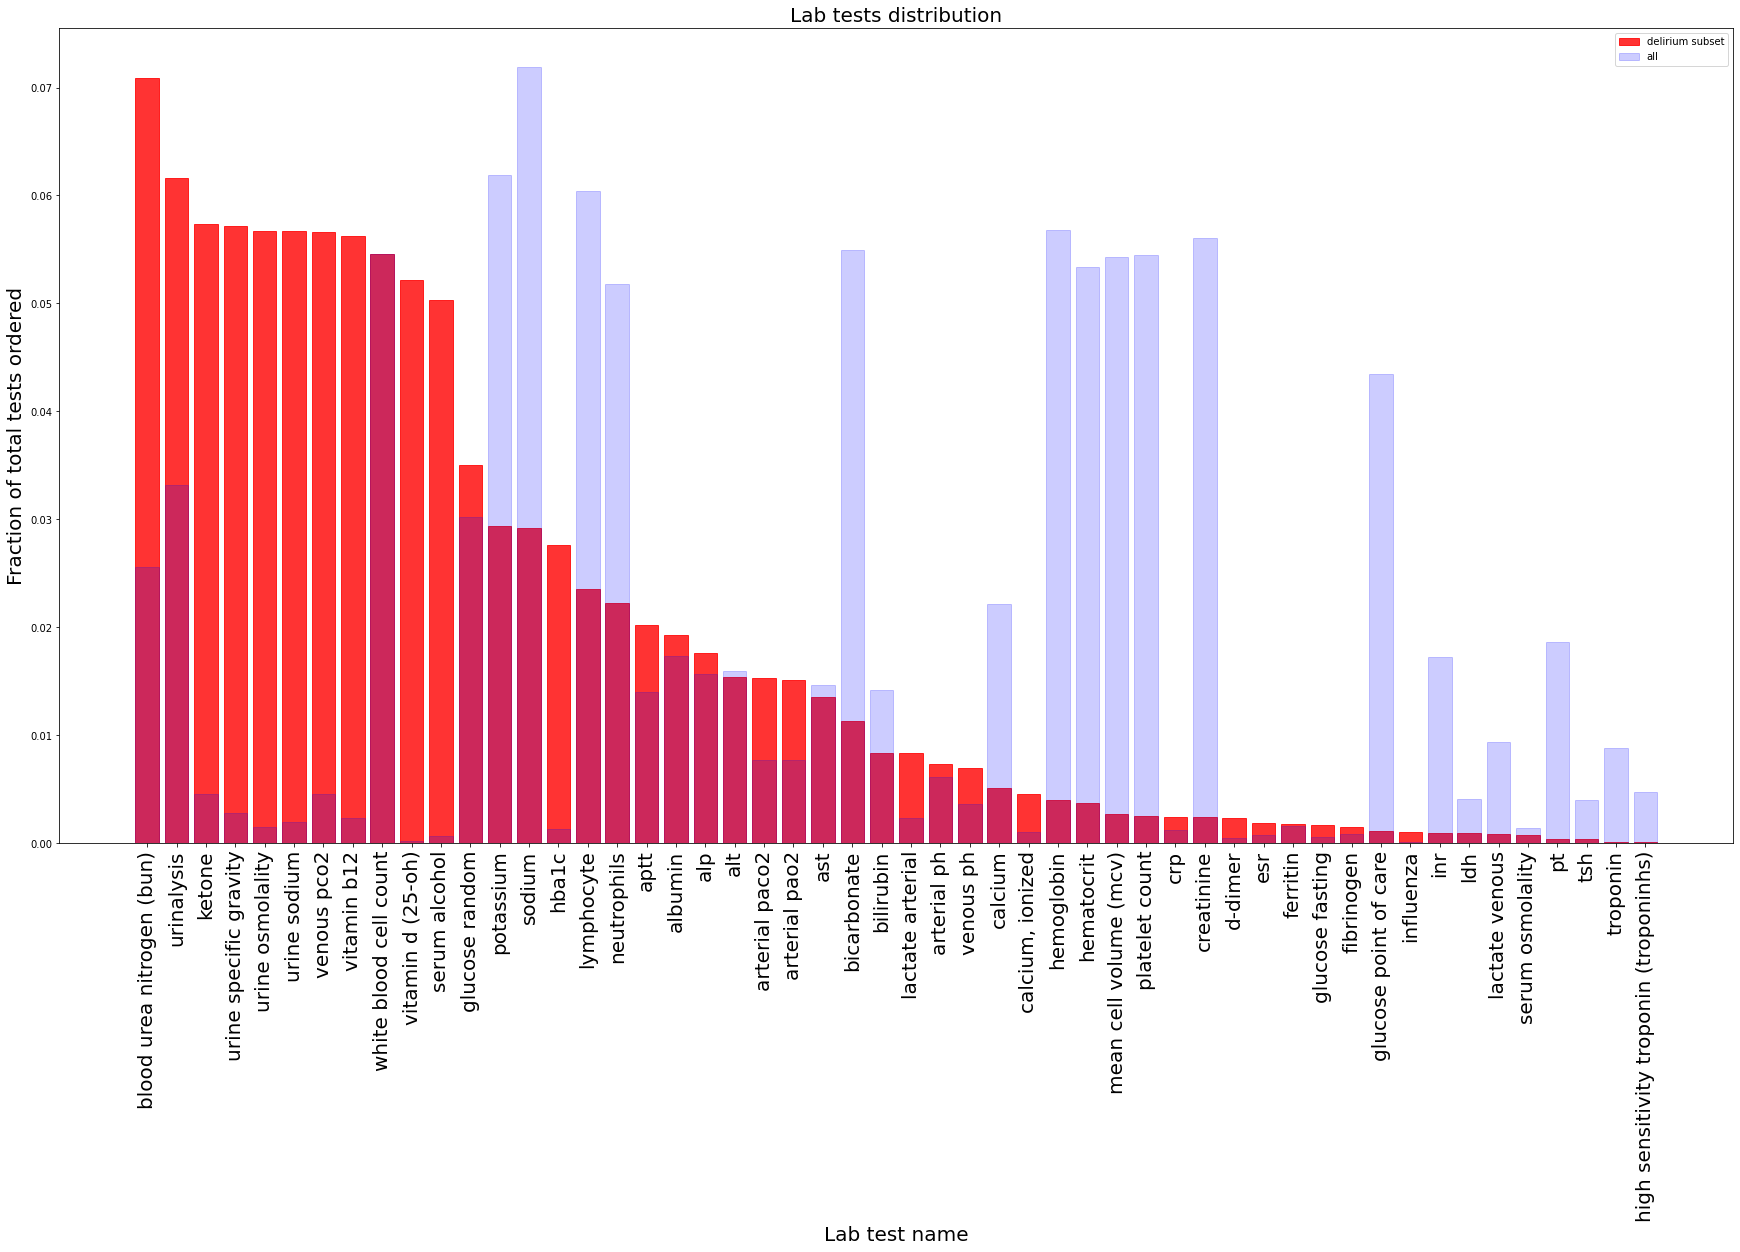

In [72]:
del_lab_names = list(labs[LAB_TEST_NAME].unique())
del_lab_counts = list(labs[LAB_TEST_NAME].value_counts())
del_lab_counts = np.array(del_lab_counts) / sum(del_lab_counts)

all_lab_counts = [int(lab_counts.loc[lab_counts["unique_lab_names"] == ln]["unique_lab_counts"]) for ln in del_lab_names]
all_lab_counts = np.array(all_lab_counts) / sum(all_lab_counts)

fig = plt.figure(figsize=(30, 15))
delirum_labs_bars = plt.bar(list(range(len(del_lab_names))), del_lab_counts, alpha = 0.8)
for bar in delirum_labs_bars:
    bar.set_color('r')
all_labs_bars = plt.bar(list(range(len(del_lab_names))), all_lab_counts, alpha = 0.2)
for bar in all_labs_bars:
    bar.set_color('b')
plt.xticks(range(len(delirum_labs_bars)), del_lab_names, rotation='vertical', fontsize=20)
plt.title("Lab tests distribution", fontsize=20)
plt.xlabel("Lab test name", fontsize=20)
plt.ylabel("Fraction of total tests ordered", fontsize=20)

lgnd = ['delirium subset', 'all']
plt.legend(lgnd, loc=1)
plt.show()